## Importación de las librerías

In [94]:
import utils
import pickle
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

## Conjuntos de entrenamiento y test y CV controller

In [95]:
X_train, X_test, y_train, y_test = utils.get_train_test_data()
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7776, 12) (1022, 12) (7776,) (1022,)


In [96]:
cv = utils.get_stratified_shuffle_cv()
print(cv)

StratifiedShuffleSplit(n_splits=5, random_state=99, test_size=0.2,
            train_size=0.8)


## Modelo de Stacking

Para el modelo de stacking se emplearán los siguientes modelos:

https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/

https://towardsdatascience.com/how-to-properly-validate-a-model-when-stacking-ad2ee1b2b9c (IDEAL)

https://stats.stackexchange.com/questions/239445/how-to-properly-do-stacking-meta-ensembling-with-cross-validation

- **Base learners**:
    - **DecisionTree** entrenado en el notebook correspondiente
    - **SVM** entrenado en el notebook correspondiente
    - **Neural network** entrenada en el notebook correspondiente

- **Meta classifier**:
    - **LogisticRegression**

In [97]:
# Importamos los modelos ya tuneados previamente
decision_tree_model = pickle.load(open('/kaggle/input/decision-tree-model/decision_tree_model.sav', 'rb'))
svc_lineal_model = pickle.load(open('/kaggle/input/svm-model/svc_lineal_model.sav', 'rb'))
nn_model = pickle.load(open('/kaggle/input/neural-network-model/nn_model.sav', 'rb'))

Comprobamos que las configuraciones están bien

In [98]:
print('criterion:', decision_tree_model.criterion, '|', decision_tree_model)
print(svc_lineal_model)
print(
    'activation:', nn_model.activation, '|',
    'solver:', nn_model.solver, '|', 'learning rate:', nn_model.learning_rate_init, '|\n',
    nn_model
)

criterion: gini | DecisionTreeClassifier(max_depth=10, min_samples_leaf=45, min_samples_split=200,
                       random_state=99)
SVC(C=0.01, kernel='linear', probability=True, random_state=99)
activation: relu | solver: adam | learning rate: 0.001 |
 MLPClassifier(hidden_layer_sizes=(40,), max_iter=1000, random_state=99,
              tol=0.005)


In [99]:
# define the base models
level0 = list()
level0.append(('decision_tree', decision_tree_model))
level0.append(('svc_lineal', svc_lineal_model))
level0.append(('nn', nn_model))

# define meta learner model
level1 = LogisticRegression(random_state=99)

# define the stacking ensemble
stacking_model = StackingClassifier(
    estimators=level0, final_estimator=level1,
    cv=5, stack_method='predict_proba', verbose=0,
    n_jobs=-1
)

scores = cross_validate(stacking_model, X_train, y_train,
                        scoring='roc_auc', return_train_score=True,
                        cv=cv, n_jobs=-1, error_score='raise')

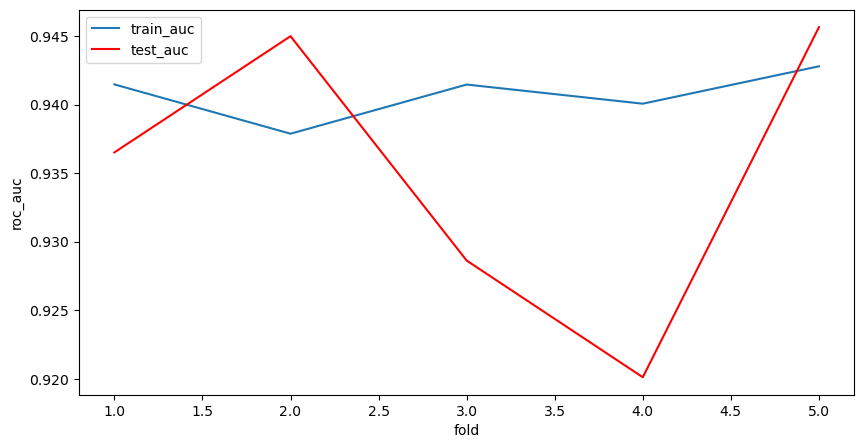

In [100]:
folds = list(range(1,6))
train_folds_scores = scores['train_score'].tolist()
test_folds_scores = scores['test_score'].tolist()

scores_df = pd.DataFrame(list(zip(folds, train_folds_scores, test_folds_scores)),
                         columns=['fold', 'fold_train_auc', 'fold_test_auc'])

fig, ax = plt.subplots(figsize=(10,5))
ax = sns.lineplot(x="fold", y="fold_train_auc", label='train_auc', data=scores_df).set(ylabel='roc_auc')
ax = sns.lineplot(x="fold", y="fold_test_auc", label='test_auc', data=scores_df, color='red')
ax.legend()

Entrenamos el **modelo final de stacking**

Confusion matrix, without normalization
[[803 169]
 [ 15  35]]


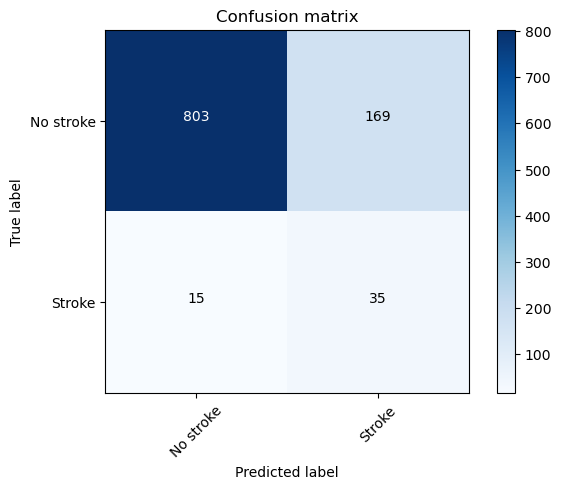

In [101]:
stacking_model = StackingClassifier(
    estimators=level0, final_estimator=level1,
    cv=5, stack_method='predict_proba', verbose=0,
    n_jobs=-1
)
stacking_model.fit(X_train, y_train)
y_pred = stacking_model.predict(X_test)

cm = utils.get_confusion_matrix(y_test, y_pred)
utils.plot_confusion_matrix(cm=cm, classes=['No stroke', 'Stroke'])

              precision    recall  f1-score   support

           0       0.98      0.83      0.90       972
           1       0.17      0.70      0.28        50

    accuracy                           0.82      1022
   macro avg       0.58      0.76      0.59      1022
weighted avg       0.94      0.82      0.87      1022



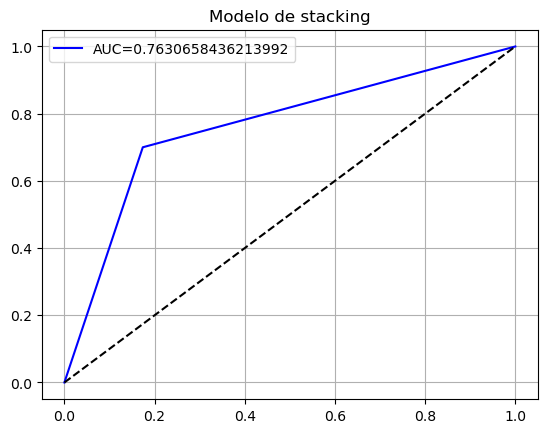

In [102]:
utils.print_metrics(y_test, y_pred, "Modelo de stacking")

## Importancia de los base learners en el meta model

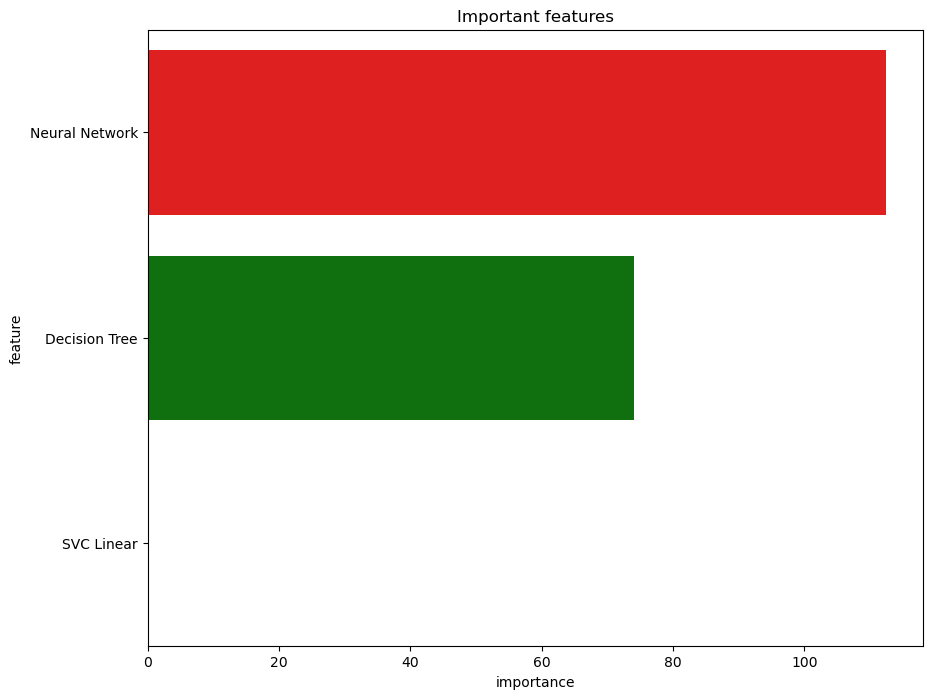

In [103]:
base_learners = ['Decision Tree', 'SVC Linear', 'Neural Network']
feature_importance = pd.DataFrame(base_learners, columns = ["base_learner"])
feature_importance["importance"] = pow(math.e, stacking_model.final_estimator_.coef_[0])
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)

utils.plot_tree_feature_importance(feature_importance.base_learner, feature_importance.importance)

Como se puede observar, el módelo SVC Linear apenas tiene importancia en la decisión final, por lo tanto procedemos a su eliminación onteniendo un stacking con la red neuronal y el árbol de decisión como base learners y LogisticRegression como meta modelo

Confusion matrix, without normalization
[[798 174]
 [ 13  37]]


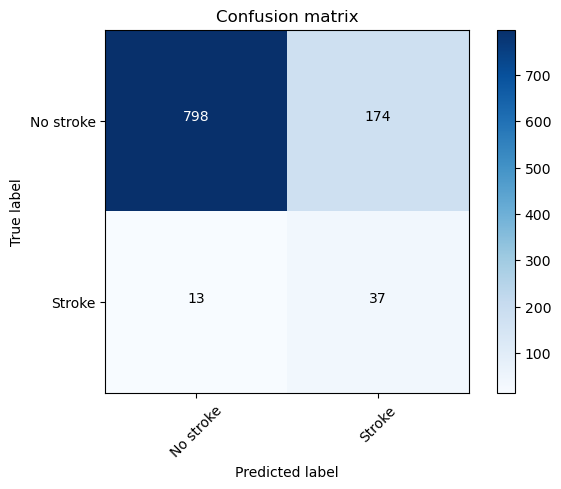

In [105]:
stacking_model = StackingClassifier(
    estimators=[level0[0], level0[2]], final_estimator=level1,
    cv=5, stack_method='predict_proba', verbose=0,
    n_jobs=-1
)
stacking_model.fit(X_train, y_train)
y_pred = stacking_model.predict(X_test)

cm = utils.get_confusion_matrix(y_test, y_pred)
utils.plot_confusion_matrix(cm=cm, classes=['No stroke', 'Stroke'])

              precision    recall  f1-score   support

           0       0.98      0.82      0.90       972
           1       0.18      0.74      0.28        50

    accuracy                           0.82      1022
   macro avg       0.58      0.78      0.59      1022
weighted avg       0.94      0.82      0.87      1022



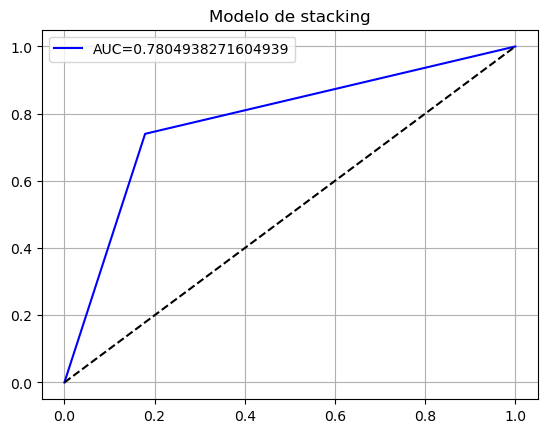

In [106]:
utils.print_metrics(y_test, y_pred, "Modelo de stacking")

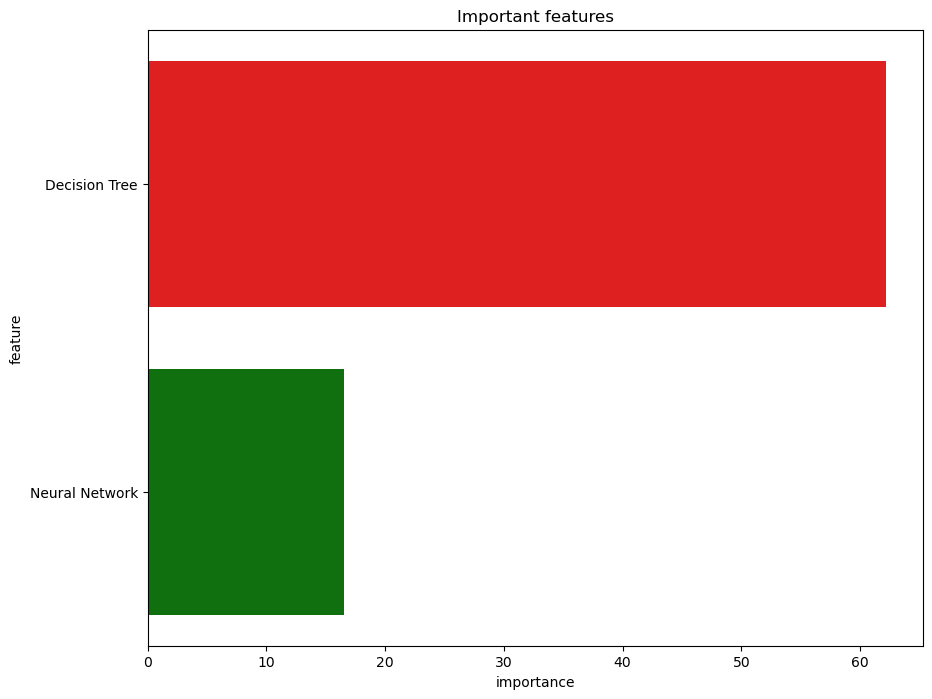

In [107]:
base_learners = ['Decision Tree', 'Neural Network']
feature_importance = pd.DataFrame(base_learners, columns = ["base_learner"])
feature_importance["importance"] = pow(math.e, stacking_model.final_estimator_.coef_[0])
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)

utils.plot_tree_feature_importance(feature_importance.base_learner, feature_importance.importance)

**NOTA**
- Tras probar diferentes combinaciones se llegó a la conclusión de que el SVC y LogisticRegression como modelos bases no aportaban nada
- No se ha querido introducir el random forest o gradient boosting o xgbosting, ni ningún otro ensemble o bagging que ha partido del árbol básico por temas de correlación.

## Guardado del modelo de stacking para la comparativa final 

In [109]:
pickle.dump(stacking_model, open("stacking_model.sav", 'wb'))